In [1]:
import os
import shutil
import tensorflow as tf
import librosa
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

project_root = Path.cwd().resolve().parent
# os.chdir(project_root)
print("Project root directory:", project_root)

2025-11-12 19:14:59.171005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Project root directory: /home/div/vsCode/Audio_classifier_Model


In [2]:
# Move audio files into class-based subdirectories
# project_root = os.path.abspath(os.getcwd())

SOURCE_DIR = os.path.join(project_root, "data", "urbansound8k")
SECONDARY_SOURCE_DIR = os.path.join(project_root, "data", "gunshot-waw", "gunshotsx_waw")
DEST_DIR = os.path.join(project_root, "data", "urbansound8k_by_class")

CLASS_MAP = {
    "0": "air_conditioner",
    "1": "car_horn",
    "2": "children_playing",
    "3": "dog_bark",
    "4": "drilling",
    "5": "engine_idling",
    "6": "gun_shot",
    "7": "jackhammer",
    "8": "siren",
    "9": "street_music",
}

os.makedirs(DEST_DIR, exist_ok=True)
counts = defaultdict(int)

# Process UrbanSound8K files
for root, _, files in os.walk(SOURCE_DIR):
    for filename in files:
        if not filename.lower().endswith(".wav"):
            continue
        stem = os.path.splitext(filename)[0]
        parts = stem.split("-")
        if len(parts) < 2:
            continue
        class_id = parts[1]
        class_name = CLASS_MAP.get(class_id)
        if class_name is None:
            continue
        target_dir = os.path.join(DEST_DIR, class_name)
        os.makedirs(target_dir, exist_ok=True)
        source_path = os.path.join(root, filename)
        target_path = os.path.join(target_dir, filename)
        if os.path.exists(target_path):
            continue
        shutil.copy2(source_path, target_path)  # switch to shutil.move(...) to relocate instead
        counts[class_name] += 1

# Process gunshot-waw files - look for folders containing "gun" in their name
if os.path.exists(SECONDARY_SOURCE_DIR):
    gun_shot_dir = os.path.join(DEST_DIR, "gun_shot")
    os.makedirs(gun_shot_dir, exist_ok=True)
    
    for root, dirs, files in os.walk(SECONDARY_SOURCE_DIR):
        # Check if current folder or any parent folder contains "gun" in the name
        folder_name = os.path.basename(root).lower()
        if "gun" in folder_name or "shot" in folder_name:
            for filename in files:
                if filename.lower().endswith(".wav"):
                    source_path = os.path.join(root, filename)
                    target_path = os.path.join(gun_shot_dir, filename)
                    if not os.path.exists(target_path):
                        shutil.copy2(source_path, target_path)
                        counts["gun_shot"] += 1

for cls, total in sorted(counts.items()):
    print(f"{cls}: {total} files")


air_conditioner: 1000 files
car_horn: 429 files
children_playing: 1000 files
dog_bark: 1000 files
drilling: 1000 files
engine_idling: 1000 files
gun_shot: 521 files
jackhammer: 1000 files
siren: 929 files
street_music: 1000 files


In [3]:
# Separate gun_shot audio files into gunshot_audio folder and other classes into non_gunshot_audio folder

BINARY_SOURCE = Path(DEST_DIR)
BINARY_DEST = BINARY_SOURCE.parent / "binary_classification"

GUNSHOT_DIR = BINARY_DEST / "gunshot_audio"
NON_GUNSHOT_DIR = BINARY_DEST / "non_gunshot_audio"

GUNSHOT_DIR.mkdir(parents=True, exist_ok=True)
NON_GUNSHOT_DIR.mkdir(parents=True, exist_ok=True)

gunshot_count = 0
non_gunshot_count = 0

for class_dir in BINARY_SOURCE.iterdir():
    if not class_dir.is_dir():
        continue
    
    is_gunshot = class_dir.name == "gun_shot"
    dest_dir = GUNSHOT_DIR if is_gunshot else NON_GUNSHOT_DIR
    
    for audio_file in class_dir.glob("*.wav"):
        target_path = dest_dir / audio_file.name
        if not target_path.exists():
            shutil.copy2(audio_file, target_path)
            if is_gunshot:
                gunshot_count += 1
            else:
                non_gunshot_count += 1

print(f"Gunshot files: {gunshot_count}")
print(f"Non-gunshot files: {non_gunshot_count}")
print(f"\nGunshot audio saved to: {GUNSHOT_DIR}")
print(f"Non-gunshot audio saved to: {NON_GUNSHOT_DIR}")

Gunshot files: 521
Non-gunshot files: 8358

Gunshot audio saved to: /home/div/vsCode/Audio_classifier_Model/data/binary_classification/gunshot_audio
Non-gunshot audio saved to: /home/div/vsCode/Audio_classifier_Model/data/binary_classification/non_gunshot_audio


In [4]:
# Data loading and preprocessing for TensorFlow model training

def load_wav_16k_mono(filename):
    """Load and resample audio file to 16kHz mono using librosa"""
    # Load audio file with librosa (handles various formats)
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    # Convert to TensorFlow tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav

# Load sample files from each category
BINARY_ROOT = Path("/home/div/vsCode/Audio_classifier_Model/data/binary_classification")

gunshot_files = list((BINARY_ROOT / "gunshot_audio").glob("*.wav"))
non_gunshot_files = list((BINARY_ROOT / "non_gunshot_audio").glob("*.wav"))

print(f"Found {len(gunshot_files)} gunshot files")
print(f"Found {len(non_gunshot_files)} non-gunshot files")

# Load and process sample files
sample_gunshot = load_wav_16k_mono(str(gunshot_files[0]))
sample_non_gunshot = load_wav_16k_mono(str(non_gunshot_files[0]))

print(f"\nGunshot sample shape: {sample_gunshot.shape}")
print(f"Non-gunshot sample shape: {sample_non_gunshot.shape}")

Found 521 gunshot files
Found 8358 non-gunshot files


I0000 00:00:1762971801.368518   88329 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



Gunshot sample shape: (39360,)
Non-gunshot sample shape: (64000,)


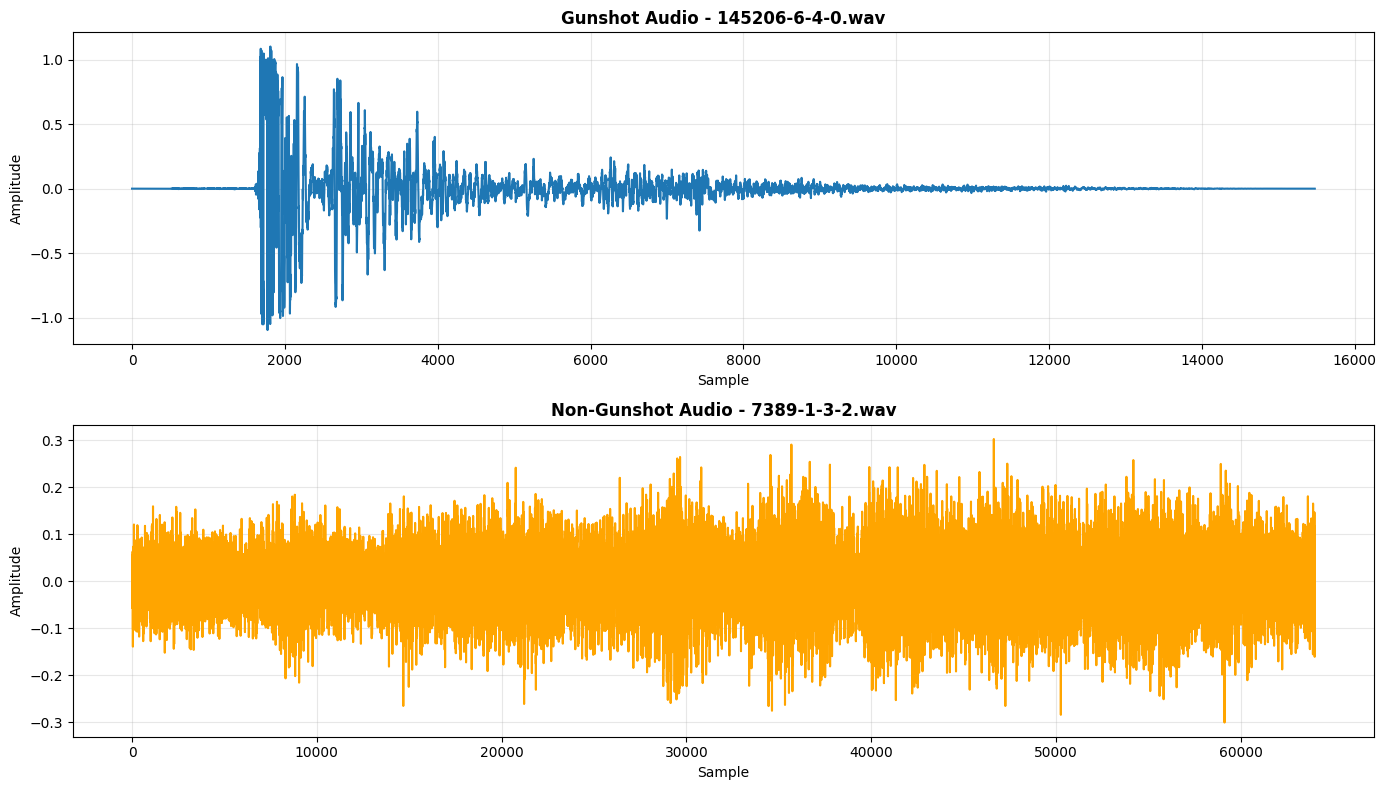

Gunshot duration: 0.97 seconds
Non-gunshot duration: 4.00 seconds


In [5]:
# Plot waveforms for gunshot vs non-gunshot samples
import random

# Randomly select files each time the cell runs
random_gunshot = random.choice(gunshot_files)
random_non_gunshot = random.choice(non_gunshot_files)

# Load the randomly selected samples
sample_gunshot_plot = load_wav_16k_mono(str(random_gunshot))
sample_non_gunshot_plot = load_wav_16k_mono(str(random_non_gunshot))

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot gunshot waveform
axes[0].plot(sample_gunshot_plot.numpy())
axes[0].set_title(f"Gunshot Audio - {random_gunshot.name}", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Sample")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, alpha=0.3)

# Plot non-gunshot waveform
axes[1].plot(sample_non_gunshot_plot.numpy(), color='orange')
axes[1].set_title(f"Non-Gunshot Audio - {random_non_gunshot.name}", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Sample")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Gunshot duration: {len(sample_gunshot_plot) / 16000:.2f} seconds")
print(f"Non-gunshot duration: {len(sample_non_gunshot_plot) / 16000:.2f} seconds")